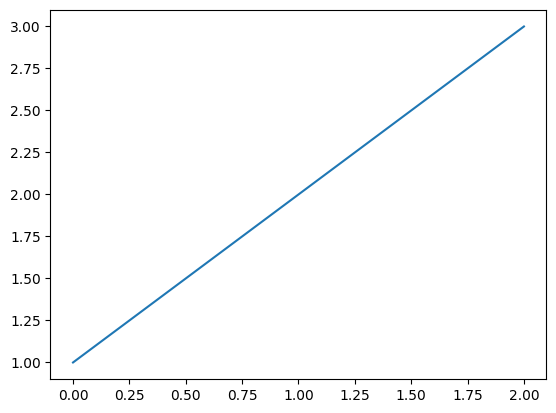

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

path = './data'

train_dataset = MNIST(path,transform=transform,download=True)
test_dataset = MNIST(path,transform=transform,download=True)

batch_size=100
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [15]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc2(hidden))
        return loc_img

In [6]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img,validate_args=False).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [68]:
vae = VAE()

In [69]:
optimizer = Adam({"lr": 1.0e-3})

In [70]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [71]:
epochs = 100

len_train_set = len(train_loader.dataset)
len_test_set = len(test_loader.dataset)

train_elbo = []
test_elbo = []
# training loop
for epoch in range(epochs):

    epoch_loss = 0.
    
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:

        pyro.clear_param_store()
        
        loss = svi.step(x)
        
        epoch_loss += loss
    
    total_epoch_loss_train = epoch_loss / len_train_set
    
    train_elbo.append(-total_epoch_loss_train)
    
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % 10 == 0:

            test_loss = 0.
            # compute the loss over the entire test set
            for x, _ in test_loader:
                test_loss += svi.evaluate_loss(x)
                
            
            average_test_loss = test_loss / len_test_set
            test_elbo.append(-total_epoch_loss_test)
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 168.9881
[epoch 000] average test loss: 104.7728
[epoch 001]  average training loss: 131.6552
[epoch 002]  average training loss: 120.3333
[epoch 003]  average training loss: 114.9972
[epoch 004]  average training loss: 112.2426
[epoch 005]  average training loss: 110.4438
[epoch 006]  average training loss: 109.2021
[epoch 007]  average training loss: 108.2471
[epoch 008]  average training loss: 107.5237
[epoch 009]  average training loss: 106.9286
[epoch 010]  average training loss: 106.5360
[epoch 010] average test loss: 104.7728
[epoch 011]  average training loss: 106.1296
[epoch 012]  average training loss: 105.8582
[epoch 013]  average training loss: 105.5598
[epoch 014]  average training loss: 105.3056
[epoch 015]  average training loss: 105.1220
[epoch 016]  average training loss: 104.9131
[epoch 017]  average training loss: 104.7083
[epoch 018]  average training loss: 104.5653
[epoch 019]  average training loss: 104.4477
[epoch 020]  average

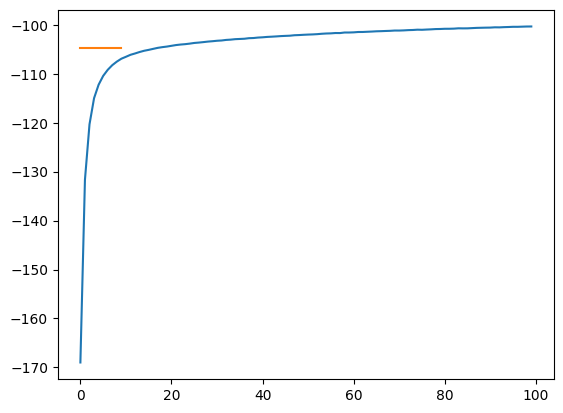

In [76]:
plt.plot(train_elbo)
plt.plot(test_elbo)

In [77]:
imgs = next(iter(test_loader))

In [78]:
x = imgs[0]

In [79]:
x = x[:10].reshape(10,28,28)

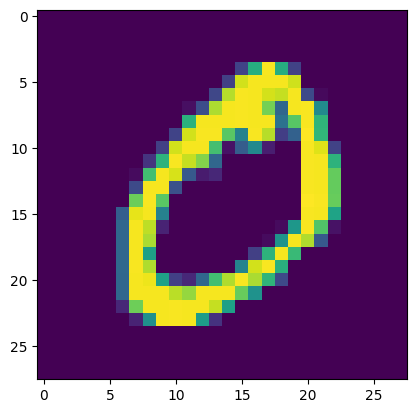

In [80]:
plt.imshow(x[1])

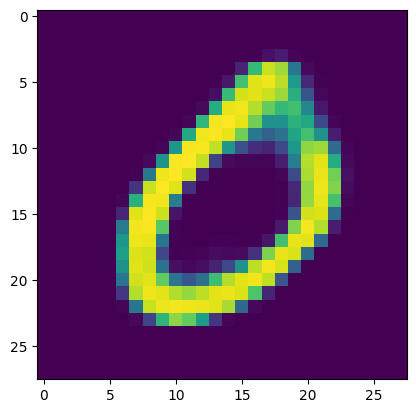

In [81]:
plt.imshow(vae.reconstruct_img(x[1]).detach().reshape(28,28))

In [74]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    

    for i in range(len(grid_y)):
        for j in range(len(grid_x)):
            z_sample = dist.Normal(torch.randn(50), torch.exp(torch.randn(50))).to_event(1).sample()
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded.detach().cpu().reshape(digit_size, digit_size).numpy()
            figure[i * digit_size : (i+1)* digit_size, j * digit_size : (j+1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

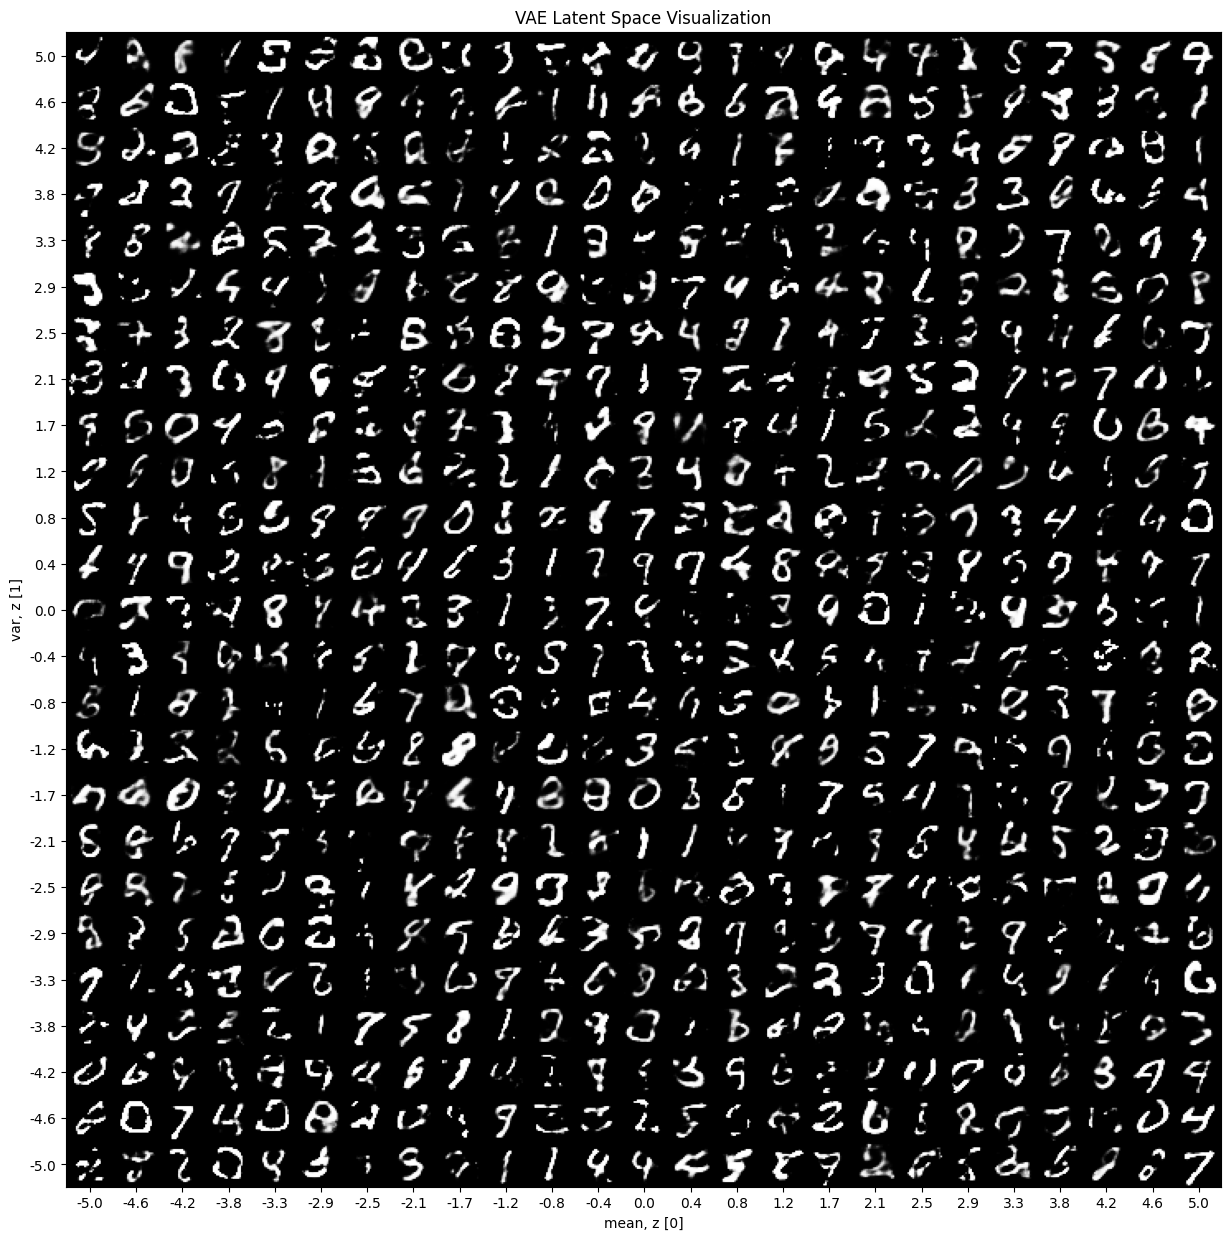

In [75]:
plot_latent_space(vae, scale=5.0, n=25, digit_size=28, figsize=15)